In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Activation
from keras.layers import GRU, LSTM
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

Using TensorFlow backend.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1MxmEN1_WaoFdkEb2Q8kSNuoFIENycq_d'}) 
downloaded.GetContentFile('prices-split-adjusted.csv')  
df = pd.read_csv('prices-split-adjusted.csv')
# Dataset is now stored in a Pandas Dataframe

In [ ]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [ ]:
df.shape

(851264, 7)

In [ ]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [ ]:
df['symbol'].nunique()

501

In [ ]:
df.isnull().sum()   # No missing data

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [ ]:
df = df[df['symbol']=='AAPL']
Code = 'AAPL'

In [ ]:
df.head()

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


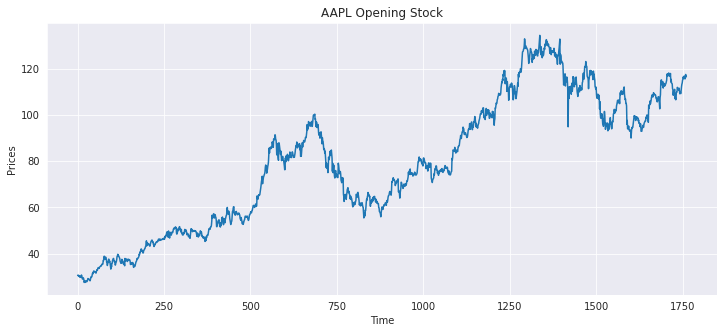

In [ ]:
sns.set_style("darkgrid")
opening = df.open.values.astype('float32')
ax = pd.Series(opening).plot(figsize=(12,5))
ax.set(xlabel='Time', ylabel='Prices', title=Code+" Opening Stock")
plt.show()

[Text(0, 0.5, 'Prices'),
 Text(0.5, 0, 'Time'),
 Text(0.5, 1.0, 'AAPL Closing Stock')]

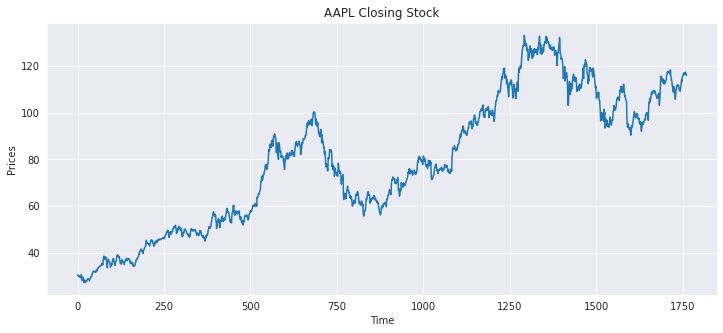

In [ ]:
closing = df.close.values.astype('float32')
bx = pd.Series(closing).plot(figsize=(12,5))
bx.set(xlabel='Time', ylabel='Prices', title=Code+" Closing Stock")

In [ ]:
apple_stock_prices = df.close.values.astype('float32')
apple_stock_prices = apple_stock_prices.reshape(len(apple_stock_prices), 1)

**Feature scaling the vector for better model performance.**

In [ ]:
scaler = MinMaxScaler()
stocks = scaler.fit_transform(apple_stock_prices)

**Splitting data into training and testing set**

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(stocks, test_size=0.2, shuffle=False)

In [ ]:
print(train.shape , test.shape)

(1409, 1) (353, 1)


**Data Processing**

In [ ]:
def process_data(data , n_features):
    """
    Process Data

    Preparing target data points based on n_features.

    Parameters
    ----------
    data : array
           given array data of (n, 1) shape.

    n_features : int
           number of features based on which target value will be computed.

    Returns
    -------
    X : numpy array
           feature array
    Y : numpy array
           target array
    """


    X, Y = [], []
    for i in range(len(data)-n_features-1):
        a = data[i:(i+n_features), 0]
        X.append(a)
        Y.append(data[i + n_features, 0])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [ ]:
n_features = 7

train_X, train_Y = process_data(train, n_features)
test_X, test_Y = process_data(test, n_features)

In [ ]:
print(train_X.shape , train_Y.shape , test_X.shape , test_Y.shape)

(1401, 7) (1401,) (345, 7) (345,)


In [ ]:
train_X = train_X.reshape(train_X.shape[0] , 1 ,train_X.shape[1])
test_X = test_X.reshape(test_X.shape[0] , 1 ,test_X.shape[1])

**Saving Best Model**

In [ ]:
filepath="best_weights.hdf5"
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

**GRU+LSTM - Model Architecture**

In [ ]:
model = Sequential()
model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 1, 256)            202752    
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 744,577
Trainable params: 744,577
Non-trainable params: 0
________________________________________________

In [ ]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005) , metrics = ['mean_squared_error'])

In [ ]:
history = model.fit(train_X, train_Y, epochs=100 , batch_size = 128 , 
          callbacks = [checkpoint , lr_reduce] , validation_data = (test_X,test_Y))

Train on 1401 samples, validate on 345 samples
Epoch 1/100
1401/1401 [==============================] - 1s 581us/step - loss: 0.1932 - mean_squared_error: 0.1932 - val_loss: 0.2385 - val_mean_squared_error: 0.2385

Epoch 00001: val_loss improved from -inf to 0.23845, saving model to best_weights.hdf5
Epoch 2/100
1401/1401 [==============================] - 0s 76us/step - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0198 - val_mean_squared_error: 0.0198

Epoch 00002: val_loss did not improve from 0.23845
Epoch 3/100
1401/1401 [==============================] - 0s 70us/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0051 - val_mean_squared_error: 0.0051

Epoch 00003: val_loss did not improve from 0.23845
Epoch 4/100
1401/1401 [==============================] - 0s 75us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0078 - val_mean_squared_error: 0.0078

Epoch 00004: val_loss did not improve from 0.23845

Epoch 00004: ReduceLROnPlateau reducing lea

[Text(0, 0.5, 'MSE'),
 Text(0.5, 0, 'epochs'),
 Text(0.5, 1.0, 'Mean Squared Error')]

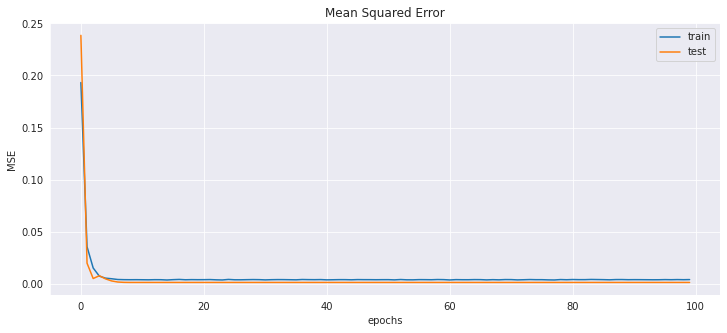

In [ ]:
ax = pd.Series(history.history['mean_squared_error']).plot(legend=True,figsize=(12,5))
bx = pd.Series(history.history['val_mean_squared_error']).plot(legend=True,figsize=(12,5))
plt.legend(['train', 'test'], loc='upper right')
ax.set(xlabel='epochs', ylabel='MSE', title="Mean Squared Error")

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'epochs'), Text(0.5, 1.0, 'Loss')]

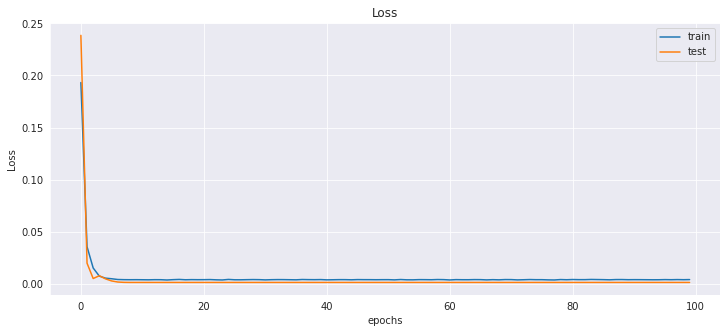

In [ ]:
ax = pd.Series(history.history['loss']).plot(legend=True,figsize=(12,5))
bx = pd.Series(history.history['val_loss']).plot(legend=True,figsize=(12,5))
plt.legend(['train', 'test'], loc='upper right')
ax.set(xlabel='epochs', ylabel='Loss', title="Loss")

In [ ]:
def model_score(model, X_train, y_train, X_test, y_test):
    """
    Model Score.

    This function returns the Root Mean Squared Score and Mean Squared Score.

    Parameters
    ----------
    X_train : array
    y_train : array
    X_test : array
    y_test : array

    Returns
    -------
    trainScore : float
          training error scores.
    testScore : float
          testing error scores.
    """


    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, train_X, train_Y , test_X, test_Y)

Train Score: 0.00208 MSE (0.05 RMSE)
Test Score: 0.00132 MSE (0.04 RMSE)


(0.002078161386441942, 0.0013217285504915576)

In [ ]:
pred = model.predict(test_X)
pred = scaler.inverse_transform(pred)

valid_Y = test_Y.reshape(test_Y.shape[0], 1)
valid_Y = scaler.inverse_transform(valid_Y)

Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


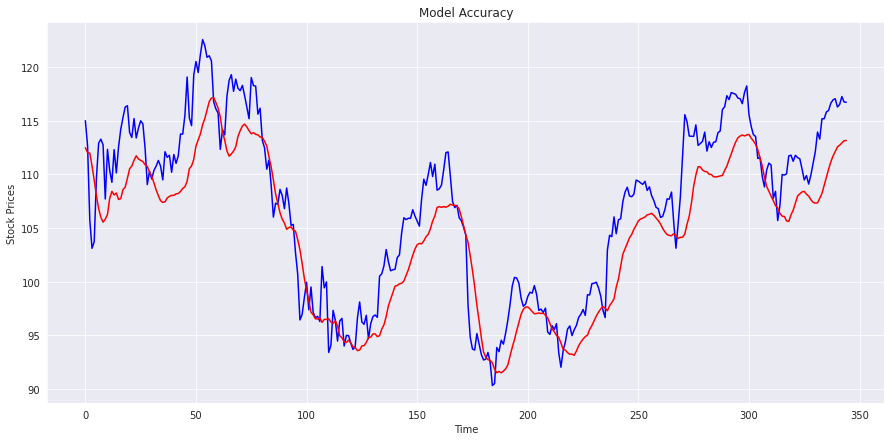

In [ ]:
print("Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(valid_Y , 'b')
plt.plot(pred , 'r')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Model Accuracy')
plt.grid(True)
plt.show()